# Imports

In [ ]:
import os
import logging
import cv2
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from PIL import Image
from numpy import ones
from numpy import zeros
from numpy.random import randint
from keras.utils.vis_utils import plot_model
from keras.initializers import RandomNormal
from keras.models import Model,Input
from keras.layers import Conv2D,MaxPool2D,Convolution2DTranspose,LeakyReLU,Dropout,BatchNormalization,Flatten,Dense,Reshape
from keras import backend as K
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/Computer Vision Course/Final Project")

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Mar 20 06:15:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print("Num GPUs Available ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available  1


# Experiment 1

## Hyper-Parameters

In [ ]:
X_path = "Data/cat_missing"
Y_path = "Data/cats"
models_path = "Models"
experiance_name = "experiment_1"

EPOCHS = 15
BATCH_SIZE = 1
IMG_DIM = 128
DATA_SPLIT = 0.1
G_LR = 0.00001 # 0.00001 worked slow
D_LR = 0.00003# 0.00003 worked slow


target_size = (IMG_DIM,IMG_DIM)
input_shape = (IMG_DIM,IMG_DIM,3)

## Loading Data

In [ ]:
def normlize(img):
  return (img / 127.5) - 1

def unnormlize(img):
  return ((img + 1) * 127.5).astype("int16")

def load_image(img_name,folder_path,img_dim = None):
    img_path = folder_path + "/" + img_name
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img_dim:
      img = cv2.resize(img, dsize=(img_dim, img_dim), interpolation=cv2.INTER_CUBIC)
    img = np.array(img)
    img = (img / 127.5) - 1
    return img.astype("float32")

In [ ]:
def load_data_as_np(X_path,Y_path,img_dim=None):
  training_binary_path = f"Data/dataset_{img_dim}.npy"

  if not os.path.isfile(training_binary_path):
    dataset = []
    for count, image in enumerate(glob.glob(f'{X_path}/*')):
      x_img = load_image(image.split(os.path.sep)[-1],X_path,img_dim)
      y_img = load_image(image.split(os.path.sep)[-1],Y_path,img_dim)
      dataset.append(np.array([x_img,y_img]))

      if count != 0 and count % 100 == 0:
        print("Loaded "+str(count)+" Images...")

    dataset = np.array(dataset)
    print(f"Saving dataset as {training_binary_path}")
    np.save(training_binary_path,dataset)

  else:
    print(f"Loading existing dataset from '{training_binary_path}'...")
    dataset = np.load(training_binary_path)
    print(f"Finished loading dataset shaped {dataset.shape}.")
  
  return dataset.astype("float32")

def np2tf_data(dataset,shuffle = False, batch_size = 1, split = 0):
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  # create train test val split
  if split != 0:
    data_size = len(dataset)
    split_size = int(data_size * split)
    test_data = dataset.take(split_size).batch(1)
    train_data = dataset.skip(split_size)
    val_data = dataset.take(split_size).batch(1)
    train_data = dataset.skip(split_size*2).batch(batch_size)
    if shuffle:
      data_size = len(train_data)
      train_data = train_data.shuffle(data_size,reshuffle_each_iteration = True)

    print(f"Data Created and split into {len(train_data)} Training images, {len(test_data)} test images, {len(val_data)} validation images")
    return train_data, test_data, val_data

  # dont create train test val split
  else:
    if shuffle:
      data_size = len(dataset) # 5652
      dataset = dataset.shuffle(data_size,reshuffle_each_iteration = True)

    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
def fill_image(missing_img, new_img):
  # assume is unnormlized
  missing_img = missing_img.copy()
  missing_block = np.array([256,256,256])
  missing_block2 = np.array([253,253,253])
  for i in range(IMG_DIM):
    for j in range(IMG_DIM):
      p1 = missing_block2 <= missing_img[i][j]
      p2 = missing_img[i][j] <= missing_block
      p = np.logical_and(p1, p2)
      if p.all():
        missing_img[i][j] = new_img[i][j]
  return missing_img

In [ ]:
def plot_image(img,unnormlize = False):
  if unnormlize:
    img = img.copy()
    img = np.array(img)
    img = (img + 1)*127.5
    img = img.astype("int32")
  plt.figure()
  plt.imshow(img)
  plt.axis('off')
  plt.show()

def plotXY(x,y,titels = ['Missing Image','Real Image']):  
  # assume is normlized
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.title(titels[0])
  x = x.numpy()
  x = (x + 1)*127.5
  x = x.astype("int32")
  plt.axis('off')
  plt.imshow(x)
  plt.subplot(1, 2, 2)
  plt.title(titels[1])
  y = y.numpy()
  y = (y + 1)*127.5
  y = y.astype("int32")
  plt.imshow(y)
  plt.axis('off')

  plt.show()

In [ ]:
train_dataset = load_data_as_np(X_path,Y_path,IMG_DIM)

Loading existing dataset from 'Data/dataset_128.npy'...
Finished loading dataset shaped (5652, 2, 128, 128, 3).


In [ ]:
train_dataset,test_dataset,val_dataset =  np2tf_data(train_dataset,shuffle = True, batch_size = BATCH_SIZE, split = DATA_SPLIT)

Data Created and split into 4522 Training images, 565 test images, 565 validation images


In [ ]:
for batch in train_dataset.take(10): 
  x,y = batch[0]
  plotXY(x,y)


Output hidden; open in https://colab.research.google.com to view.

## Generator

In [ ]:
def encoder_block(input, n_filters, filter_size=(3,3), stride=(2,2), activation = LeakyReLU(alpha=0.2), batchnorm=True):
  g = Conv2D(n_filters, filter_size, strides=stride, activation = activation,padding='same')(input)

  if batchnorm:
    g = BatchNormalization()(g, training=True)

  return g

def decoder_block(layer_in, n_filters, filter_size=(3,3), stride=(2,2),activation = LeakyReLU(alpha=0.2), padding='same', dropout=False, batchnorm=True):
  g = Convolution2DTranspose(n_filters, filter_size, strides=stride,activation = activation, padding=padding)(layer_in)
  if batchnorm:
    g = BatchNormalization()(g, training=True)
  if dropout:
    g = Dropout(0.5)(g, training=True)

  return g

def define_generator(image_shape=(128, 128, 3), print = False):
  in_image = Input(shape=image_shape) #128x128x3
 
  e1 = encoder_block(in_image, 64, batchnorm=False)
  if print:
    print(e1.shape) #64x64x64
  e2 = encoder_block(e1, 128)
  if print:
    print(e2.shape) #32x32x128
  e3 = encoder_block(e2, 256)
  if print:
    print(e3.shape) #16x16x256
  e4 = encoder_block(e3, 512)
  if print:
    print(e4.shape) #8x8x512
  e5 = encoder_block(e4, 512)
  if print:
    print(e5.shape) #4x4x512
  
  embeded = Flatten()(e5) #8,192
  fc1 = Dense(8192, activation=LeakyReLU(alpha=0.2))(embeded)
  if print:
    print(fc1.shape) #8192

  d0 = Reshape(target_shape=(4, 4, 512))(fc1)#4x4x512
  if print:
    print(d0.shape) #4x4x512
  d1 = decoder_block(d0 ,512)
  if print:
    print(d1.shape) #8x8x512
  d2 = decoder_block(d1, 256)
  if print:
    print(d2.shape) #16x16x256
  d3 = decoder_block(d2, 128)
  if print:
    print(d3.shape) #32x32x128
  d4 = decoder_block(d3, 64)
  if print:
    print(d4.shape) #64x64x64
  out_image = decoder_block(d4, 3,activation = "tanh",batchnorm=False)
  if print:
    print(out_image.shape) #128x128x3

  model = Model(in_image, out_image)
  return model

In [ ]:
generator = define_generator(input_shape)
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                             

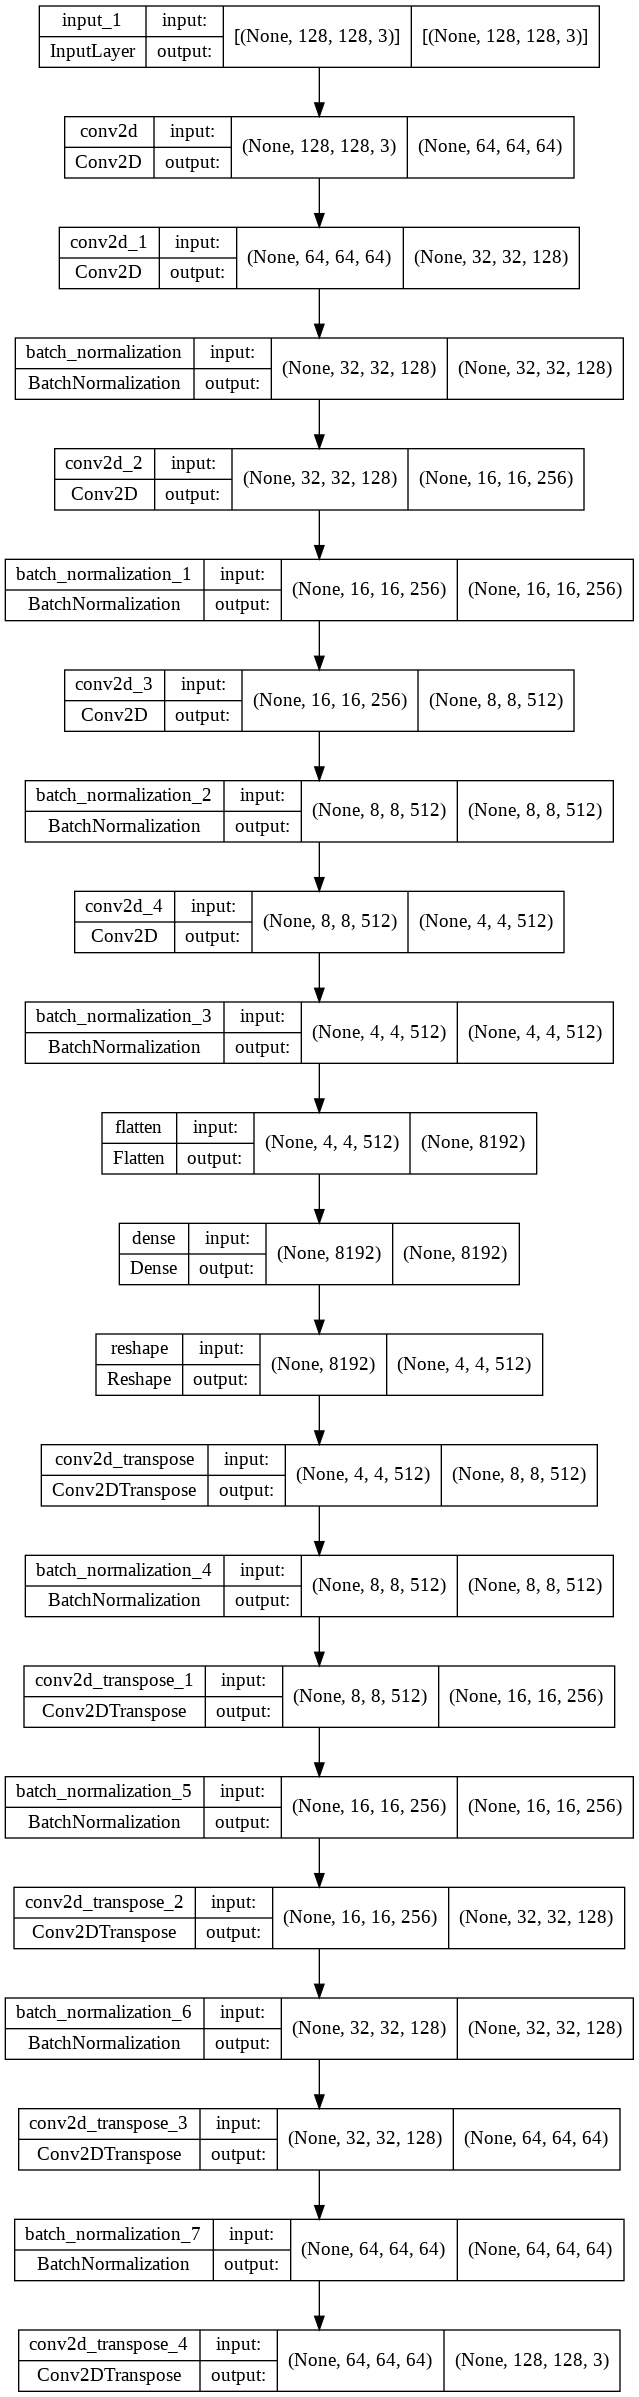

In [ ]:
plot_model(generator, show_shapes=True, show_layer_names=True)

## Discriminator

In [ ]:
def define_discriminator(input_shape=(128, 128, 3)):

  activation = LeakyReLU(alpha=0.2)
  filter_size=(3,3)
  stride=(2,2)
  l0 = Input(shape=input_shape)
  d = Conv2D(64, filter_size, strides=stride,activation = activation, padding='same')(l0)
  d = Conv2D(128, filter_size, strides=stride,activation = activation, padding='same')(d)
  d = BatchNormalization()(d, training=True)
  d = Conv2D(256, filter_size, strides=stride,activation = activation, padding='same')(d)
  d = Conv2D(512, filter_size, strides=stride,activation = activation, padding='same')(d)
  d = BatchNormalization()(d, training=True)
  d = Flatten()(d)
  d = Dense(512, activation=activation)(d)
  d = BatchNormalization()(d, training=True)
  d = Dense(256, activation=activation)(d)
  output = Dense(1, activation="sigmoid")(d)

  model = Model(l0, output)
  return model

In [ ]:
discriminator = define_discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 512)         1180160   
                                                           

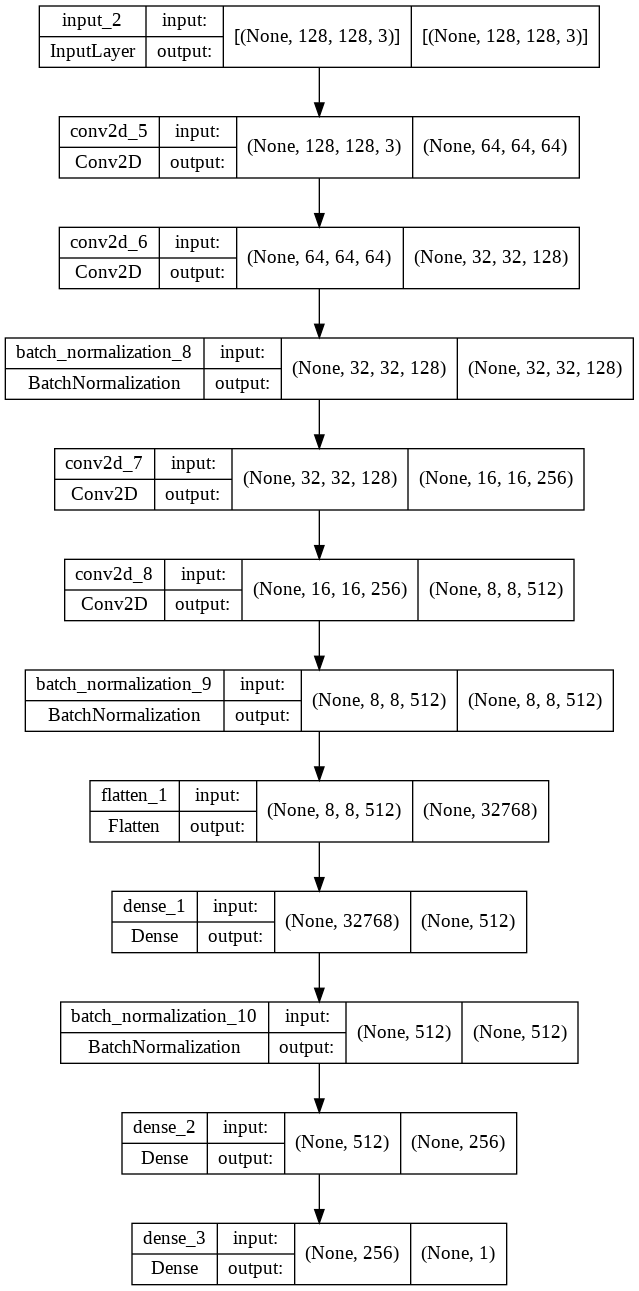

In [ ]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

## Training

In [ ]:
def plot_prediction(missing_img, real_img, generated_img):
  plt.figure(figsize=(10, 10))

  plt.subplot(1, 4, 1)
  plt.title('Missing Image')
  missing_img = missing_img.copy()
  missing_img = (missing_img + 1)*127.5
  missing_img = missing_img.astype("int32")
  plt.axis('off')
  plt.imshow(missing_img)

  plt.subplot(1, 4, 2)
  plt.title('Real Image')
  real_img = real_img.copy()
  real_img = (real_img + 1)*127.5
  real_img = real_img.astype("int32")
  plt.imshow(real_img)
  plt.axis('off')

  plt.subplot(1, 4, 3)
  plt.title('Full Generated Image')
  generated_img = generated_img.copy()
  generated_img = (generated_img + 1)*127.5
  generated_img = generated_img.astype("int32")
  plt.axis('off')
  plt.imshow(generated_img)

  plt.subplot(1, 4, 4)
  plt.title('Generated Image')
  generated_img = fill_image(missing_img,generated_img)
  plt.imshow(generated_img)
  plt.axis('off')

  plt.show()

In [ ]:
def d_train_batch(batch, g_model, d_model, d_optimizer,loss_func,d_acc_metric):
  batch_size = tf.shape(batch)[0]
  y_true = tf.concat([tf.ones(batch_size,dtype=tf.dtypes.float32),tf.zeros(batch_size,dtype=tf.dtypes.float32)], axis = 0)#[1,1,1,0,0,0]

  missing_imgs = batch[:,0]
  real_imgs = batch[:,1]

  with tf.GradientTape() as tape:
    fake_imgs = g_model(missing_imgs, training=False)
    x = tf.concat([real_imgs, fake_imgs], axis=0)#[r,r,r,f,f,f]
    y_pred = d_model(x, training=True)
    d_loss = loss_func(y_true,  y_pred)

  gradients = tape.gradient(d_loss, d_model.trainable_weights)
  d_optimizer.apply_gradients(zip(gradients, d_model.trainable_weights))
  d_acc_metric.update_state(y_true, y_pred)

  visualization_loss = {
      'discriminator_loss' : d_loss,
      'discriminator_acc' : d_acc_metric.result()
  }
  
  return visualization_loss


In [ ]:
alpha = 0.1
mse = tf.keras.losses.MeanSquaredError()
bce = BinaryCrossentropy(from_logits=True)

def g_train_batch(batch, g_model, d_model, g_optimizer,g_adv_acc_metric,plot = False):
  batch_size = tf.shape(batch)[0]
  missing_imgs = batch[:,0]
  real_imgs = batch[:,1]
  y_true = tf.ones(batch_size,dtype=tf.dtypes.float32) #[1,1,1]

  with tf.GradientTape() as tape:
    generated_imgs = g_model(missing_imgs, training=True)
    y_pred = d_model(generated_imgs, training=False)
    g_loss = alpha * bce(y_true,  y_pred) + (1-alpha) * mse(K.flatten(real_imgs),K.flatten(generated_imgs))
  
  if plot:
      plotXY(generated_imgs[0],real_imgs[0],titels = ["Full Generated Image", "Real Image"])
  
  gradients = tape.gradient(g_loss, g_model.trainable_weights)
  g_optimizer.apply_gradients(zip(gradients, g_model.trainable_weights))

  g_adv_acc_metric.update_state(y_true, y_pred)
  adv_acc = g_adv_acc_metric.result()

  visualization_loss = {
      'generator_adv_loss' : bce(y_true,  y_pred),
      'generator_adv_acc' : adv_acc,
      'generator_mse_loss' : mse(K.flatten(real_imgs),K.flatten(generated_imgs)),
      'generator_total_loss' : g_loss
  }
  
  return visualization_loss

In [ ]:
def train_gan(train_dataset, val_dataset,epochs, g_model,d_model,d_loss_func, g_optimizer,d_optimizer,g_acc_metric,d_acc_metric):
  # vars to track history
  history_g_loss = []
  history_g_adv_accuracy = []
  history_d_loss = []
  history_d_accuracy = []

  time = timer()
  # epoch
  for epoch in range(epochs):

    # vars to track loss in epoch
    g_total_loss = 0
    g_adv_loss_sum = 0
    g_mse_loss_sum = 0
    d_loss_sum = 0

    counter = 0
    for batch in train_dataset:
      d_loss = d_train_batch(batch, g_model, d_model, d_optimizer,d_loss_func,d_acc_metric)
      d_loss_sum += d_loss['discriminator_loss']

      g_loss = g_train_batch(batch, g_model, d_model, g_optimizer,g_acc_metric)
      g_total_loss += g_loss["generator_total_loss"]
      g_adv_loss_sum += g_loss['generator_adv_loss']
      g_mse_loss_sum += g_loss['generator_mse_loss']

      counter += 1
      print("\r"+"Epoch number: {}/{}, Batch: {}/{}, G Loss:{:0.4f}, G Adv Accuracy:{:0.4f}%, D Loss:{:0.4f}, D Accuracy:{:0.4f}%".format(
          epoch+1,epochs,counter,len(train_dataset),g_total_loss/counter,g_acc_metric.result()*100,d_loss_sum/counter,d_acc_metric.result()*100), end="")

    # vars to summorize epoch for printing and history
    g_epoch_total_loss = g_total_loss / counter
    g_epoch_reconstruction_loss = g_mse_loss_sum / counter
    g_epoch_adv_loss = g_adv_loss_sum / counter
    g_epoch_adv_acc = g_acc_metric.result() * 100
    d_epoch_loss = d_loss_sum / counter
    d_epoch_acc = d_acc_metric.result() * 100

    # appending history
    history_g_loss.append(g_epoch_total_loss)
    history_g_adv_accuracy.append(g_epoch_adv_acc)
    history_d_loss.append(d_epoch_loss)
    history_d_accuracy.append(d_epoch_acc)

    # printing
    print("\n\nFinished Epoch: {},\nGenerator Combined Loss:{:0.4f},\nGenerator Reconstruction Loss:{:0.4f},\nGenerator Adversarial Loss:{:0.4f}, Generator Adversarial Acc:%{:0.2f},\nDiscriminator Loss:{:0.4f}, Discriminator Acc:%{:0.2f}".format(
      epoch+1,g_epoch_total_loss,g_epoch_reconstruction_loss,g_epoch_adv_loss,g_epoch_adv_acc,d_epoch_loss,d_epoch_acc))

    # reseting accuracy
    g_acc_metric.reset_state()
    d_acc_metric.reset_state()

    # plotting from validation
    num_val_plots = 5
    index = random.randrange(len(val_dataset) - num_val_plots)
    for i, batch in enumerate(val_dataset.skip(index)):
      missing_img = batch[0,0]
      real_img= batch[0,1]
      generated_img = generator(np.array([missing_img]))
      plot_prediction(missing_img.numpy(), real_img.numpy(), generated_img[0].numpy())
      if i > num_val_plots:
        break

    if epoch >= 10:
      g_model.save(models_path+f"/{experiance_name}_g.h5")
      d_model.save(models_path+f"/{experiance_name}_d.h5")

  total_time = round((timer() - time)/60)
  print(f"Finished training after {total_time} minutes.")

  history = {}

  history['g_loss'] = history_g_loss
  history['g_accuracy'] = history_g_adv_accuracy
  history['d_loss'] = history_d_loss
  history['d_accuracy'] = history_d_accuracy

  return history

In [ ]:
g_optimizer = Adam(learning_rate=G_LR, beta_1=0.5)
d_optimizer = Adam(learning_rate=D_LR, beta_1=0.5)

d_loss_func = BinaryCrossentropy(from_logits=True)

g_acc_metric = BinaryAccuracy()
d_acc_metric = BinaryAccuracy()

In [ ]:
history = train_gan(train_dataset, val_dataset,EPOCHS, generator,discriminator,d_loss_func, g_optimizer,d_optimizer,g_acc_metric,d_acc_metric)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
generator.save(models_path+f"/{experiance_name}_g.h5")
discriminator.save(models_path+f"/{experiance_name}_d.h5")

## Evaluate

In [ ]:
def plot_loss(history):
  plt.plot(history['g_loss'])
  plt.plot(history['d_loss'])
  plt.title('gan loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['generator', 'discriminator'], loc='upper left')
  plt.show()

def plot_accuracy(history):
  plt.plot(history['g_accuracy'])
  plt.plot(history['d_accuracy'])
  plt.title('gan accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['generator', 'discriminator'], loc='upper left')
  plt.show()


def plot_history(history):
  plot_loss(history)
  plot_accuracy(history)

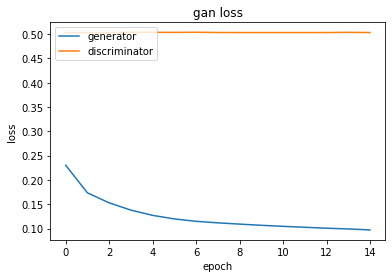

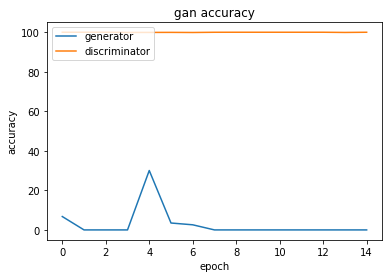

In [ ]:
plot_history(history)

In [ ]:
num_val_plots = 20
index = random.randrange(len(test_dataset) - num_val_plots)
for i, batch in enumerate(test_dataset.skip(index)):
  missing_img = batch[0,0]
  real_img= batch[0,1]
  generated_img = generator(np.array([missing_img]))
  plot_prediction(missing_img.numpy(), real_img.numpy(), generated_img[0].numpy())
  if i > num_val_plots:
    break

Output hidden; open in https://colab.research.google.com to view.